In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


## テストデータなどの導入

In [6]:
import pandas as pd
import numpy as np
import ydata_profiling # pandas_profiling は 2023-04-01 に非推奨　https://blog.amedama.jp/entry/rename-to-ydata-profiling
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Geod
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.4f' % x)

TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

## 欠損値チェック、データの範囲を確かめるコード

In [7]:
test = pd.read_csv(TEST_PATH)
print('Null values:',test.isnull().sum().sum())
test.head()

Null values: 0


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.9733,40.7638,-73.9814,40.7438,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.9869,40.7194,-73.9989,40.7392,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.9825,40.7513,-73.9797,40.7461,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.9812,40.7678,-73.9904,40.7516,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.9660,40.7898,-73.9886,40.7444,1


## 大量のデータを読むため、サブセット読み込み

In [8]:
df_temp = pd.read_csv(TRAIN_PATH, nrows=100000)
profile = ydata_profiling.ProfileReport(df_temp, title="Profile Report", minimal=True, progress_bar=False)
profile.to_notebook_iframe()

In [9]:
df_temp

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5000,2009-06-15 17:26:21 UTC,-73.8443,40.7213,-73.8416,40.7123,1
1,2010-01-05 16:52:16.0000002,16.9000,2010-01-05 16:52:16 UTC,-74.0160,40.7113,-73.9793,40.7820,1
2,2011-08-18 00:35:00.00000049,5.7000,2011-08-18 00:35:00 UTC,-73.9827,40.7613,-73.9912,40.7506,2
3,2012-04-21 04:30:42.0000001,7.7000,2012-04-21 04:30:42 UTC,-73.9871,40.7331,-73.9916,40.7581,1
4,2010-03-09 07:51:00.000000135,5.3000,2010-03-09 07:51:00 UTC,-73.9681,40.7680,-73.9567,40.7838,1
...,...,...,...,...,...,...,...,...
99995,2013-09-24 07:39:00.00000071,9.0000,2013-09-24 07:39:00 UTC,-73.9480,40.7848,-73.9643,40.7923,5
99996,2014-05-15 12:15:45.0000001,6.0000,2014-05-15 12:15:45 UTC,-73.9629,40.7991,-73.9742,40.7865,1
99997,2015-02-19 17:40:43.0000001,5.0000,2015-02-19 17:40:43 UTC,-73.9968,40.7235,-73.9920,40.7247,1
99998,2009-10-10 23:35:00.000000165,6.9000,2009-10-10 23:35:00 UTC,-73.9837,40.7567,-73.9827,40.7671,4


## 上記の結果より、変な値があることがわかったので確認する

In [5]:
df_temp[df_temp['pickup_longitude']>0].head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2147,2013-05-24 14:54:00.00000079,5.0000,2013-05-24 14:54:00 UTC,40.7516,-73.9870,40.7589,-73.9784,2
3827,2013-06-20 04:28:00.0000001,11.0000,2013-06-20 04:28:00 UTC,40.7198,-73.9885,40.7233,-73.9394,1
4783,2013-05-22 06:28:00.0000004,6.5000,2013-05-22 06:28:00 UTC,40.7483,-73.9918,40.7404,-73.9790,1
6705,2013-05-22 15:33:00.000000175,13.0000,2013-05-22 15:33:00 UTC,40.7661,-73.9833,40.7574,-73.9780,2
7525,2013-05-22 10:54:00.000000140,13.0000,2013-05-22 10:54:00 UTC,40.7605,-73.9730,40.7404,-73.9944,1


## 間違いあったので、変更しつつ、データを読み込む

In [6]:
def clean_df(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 15)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    #reverse incorrectly assigned longitude/latitude values
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    
    #remove data points outside appropriate ranges
    criteria = (
    " 0 < fare_amount <= 500"
    " and 0 < passenger_count <= 6 "
    " and -75 <= pickup_longitude <= -72 "
    " and -75 <= dropoff_longitude <= -72 "
    " and 40 <= pickup_latitude <= 42 "
    " and 40 <= dropoff_latitude <= 42 "
    )
    df = (df
          .dropna()
          .query(criteria)
          .reset_index()
          .drop(columns=['rev', 'index'])          
         )
    return df

def load_df(nrows=None, features=None):
    #load dataframe in chunks if the number of rows requested is high (currently only using 1 million rows for faster training)
    cols = [
        'fare_amount', 'pickup_datetime','pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'
    ]
    df_as_list = []
    for df_chunk in pd.read_csv(TRAIN_PATH, usecols=cols, nrows=nrows, chunksize=5000000):
        df_chunk = clean_df(df_chunk) 
        if features == 'explore':
            df_chunk = exploration_features(df_chunk)
        elif features == 'model':
            df_chunk = modelling_features(df_chunk)
        else:
            df_chunk = df_chunk.drop(columns='pickup_datetime')
        df_as_list.append(df_chunk)
    df = pd.concat(df_as_list)
    return df

## 実行時間を減らすため、1000万行しか使わないように設定する
5000万行ではなく、1000万行のみを使う。この1000万行のデータセットのことを「サブセット」と呼ぶ。以下のコードでサブセットを読み込む。5000万行読み込まなくても、サブセットの中身がちゃんとしていることが分かったため、サブセットを用いて訓練する。

In [7]:
train = load_df(10000000)
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9758850.0000,9758850.0000,9758850.0000,9758850.0000,9758850.0000,9758850.0000
mean,11.3297,-73.9752,40.7510,-73.9743,40.7514,1.6908
std,9.6978,0.0391,0.0300,0.0383,0.0332,1.3066
min,0.0100,-74.9899,40.0000,-74.9983,40.0000,1.0000
25%,6.0000,-73.9923,40.7365,-73.9916,40.7356,1.0000
50%,8.5000,-73.9821,40.7533,-73.9806,40.7539,1.0000
75%,12.5000,-73.9683,40.7675,-73.9654,40.7684,2.0000
max,500.0000,-72.0632,41.9839,-72.0670,41.9981,6.0000


## データは非線形性を持つだろう。どの方法がいいのかを考える
線形回帰、KNN、勾配ブースティング木、RMSEのどれがいいかを、以下のコードを回して確認してみる

In [8]:
def get_split_sets(train):
    x = train.drop(columns=['fare_amount'])
    y = train['fare_amount'].values
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=0)
    return x_train, x_val, y_train, y_val


def lin_model(x_train, x_val, y_train, y_val):
    model = LinearRegression()
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred


def knn_model(x_train, x_val, y_train, y_val, neighbors):
    min_rmse = 1000
    for n in neighbors:
        knn = KNeighborsRegressor(n_neighbors=n)
        knn.fit(x_train, y_train)
        pred = knn.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        if rmse < min_rmse:
            min_rmse = rmse
            model = knn
            best_pred = pred
        print('Neighbours', n, 'RMSE', rmse)
    return model, min_rmse, best_pred


def lgbm_model(params,x_train, x_val, y_train, y_val):
    lgbm_train = lgbm.Dataset(x_train, y_train) # delete silent=True
    # FutureWarningを出力させたくない場合は引数silent=Trueを合わせて指定する。
    # https://note.nkmk.me/python-pandas-option-setting/
    lgbm_val = lgbm.Dataset(x_val, y_val) # delete silent=True
    model = lgbm.train(params=params, train_set=lgbm_train, valid_sets=lgbm_val, callbacks=[lgbm.log_evaluation(period=100)]) # verbose=100は使えない　https://zenn.dev/local/articles/e2e6de3959e96d
    pred = model.predict(x_val, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return model, rmse, pred

In [9]:
train = load_df(1000000)
x_train, x_val, y_train, y_val= get_split_sets(train)
test = pd.read_csv(TEST_PATH)
x_test = test.drop(columns=['key'])

In [10]:
lin_init_model, lin_init_rmse, lin_init_pred = lin_model(x_train, x_val, y_train, y_val)

In [11]:
k_choices = [10,20,30,40,50,60]
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
knn_init, knn_init_rmse, knn_init_pred = knn_model(x_train[knn_cols], x_val[knn_cols], y_train, y_val, k_choices)

Neighbours 10 RMSE 4.072998476506057
Neighbours 20 RMSE 4.041159426812784
Neighbours 30 RMSE 4.020953626643561
Neighbours 40 RMSE 4.035091868055065
Neighbours 50 RMSE 4.0544035378283745
Neighbours 60 RMSE 4.06410488649269


In [12]:
lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'num_leaves': 400,
    'learning_rate': 0.1,
    'max_bin': 3000,
    'num_rounds': 5000,
    'early_stopping_rounds': 100,
    'metric' : 'rmse'
}
lgbm_init_model, lgbm_init_rmse, lgbm_init_pred = lgbm_model(lgbm_params, x_train, x_val, y_train, y_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12007
[LightGBM] [Info] Number of data points in the train set: 878552, number of used features: 5
[LightGBM] [Info] Start training from score 11.340506
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 4.02757
Early stopping, best iteration is:
[87]	valid_0's rmse: 4.02609


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

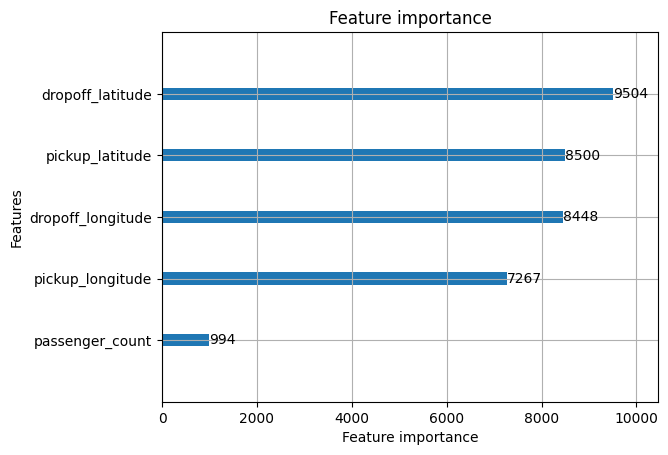

In [13]:
lgbm.plot_importance(lgbm_init_model)

In [14]:
print('Linear Regression RMSE', lin_init_rmse)
print('KNN RMSE', knn_init_rmse)
print('LightGBM RMSE', lgbm_init_rmse)

Linear Regression RMSE 8.302046575702477
KNN RMSE 4.020953626643561
LightGBM RMSE 4.02609480074296


## KNNは、線形よりいいくらいLightGBMはKNNと同値、しかも乗客数を使用しない方法であった。

In [15]:
init_preds_ave = (lgbm_init_pred+knn_init_pred)/2
rmse = np.sqrt(mean_squared_error(y_val, init_preds_ave))
print('Combined RMSE: ', rmse)

Combined RMSE:  3.9583965554000886


## ↑上記は線形回帰モデル以外の方法でRMSEを求めた結果である。

## 可視化用の特徴抽出関数を作成

In [16]:
def distance(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return dist
def direction(lon1,lat1,lon2,lat2):
    az12,az21,dist = Geod(ellps='WGS84').inv(lon1,lat1,lon2,lat2)
    return az12

def shared_features(df):
    """adds features that will be used by both the modelling and EDA dataframes"""
    rows = len(df)
    #these long/lat values are needed as lists to hand to the distance function
    nyc_long, nyc_lat = [-74.001541]*rows, [40.724944]*rows    
    jfk_long, jfk_lat = [-73.785937]*rows, [40.645494]*rows
    lga_long, lga_lat = [-73.872067]*rows, [40.774071]*rows
    nla_long, nla_lat = [-74.177721]*rows, [40.690764]*rows
    chp_long, chp_lat = [-73.137393]*rows, [41.366138]*rows
    exp_long, exp_lat = [-74.0375]*rows, [40.736]*rows
    pickup_long = df.pickup_longitude.tolist()
    pickup_lat = df.pickup_latitude.tolist()
    dropoff_long = df.dropoff_longitude.tolist()
    dropoff_lat = df.dropoff_latitude.tolist()
    
    #add features to the data
    df = df.assign(
        #time features
        year=df.pickup_datetime.dt.year,
        dayofyear=df.pickup_datetime.dt.dayofyear,
        weekday=df.pickup_datetime.dt.dayofweek,
        time=(df.pickup_datetime.dt.hour+df.pickup_datetime.dt.minute/5),
        
        #distance between pickup and dropoff, and bearing from pickup to dropoff
        distance=distance(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        direction=direction(pickup_long, pickup_lat, dropoff_long, dropoff_lat),
        
        #distance from locations
        pickup_dist_nyc=pd.Series(distance(pickup_long, pickup_lat, nyc_long, nyc_lat)),
        dropoff_dist_nyc=pd.Series(distance(dropoff_long, dropoff_lat, nyc_long, nyc_lat)),
        pickup_dist_jfk=pd.Series(distance(pickup_long, pickup_lat, jfk_long, jfk_lat)),
        dropoff_dist_jfk=pd.Series(distance(dropoff_long, dropoff_lat, jfk_long, jfk_lat)),
        pickup_dist_lga=pd.Series(distance(pickup_long, pickup_lat, lga_long, lga_lat)),
        dropoff_dist_lga=pd.Series(distance(dropoff_long, dropoff_lat, lga_long, lga_lat)),
        pickup_dist_nla=pd.Series(distance(pickup_long, pickup_lat, nla_long, nla_lat)),
        dropoff_dist_nla=pd.Series(distance(dropoff_long, dropoff_lat, nla_long, nla_lat)),
        pickup_dist_chp=pd.Series(distance(pickup_long, pickup_lat, chp_long, chp_lat)),
        dropoff_dist_chp=pd.Series(distance(dropoff_long, dropoff_lat, chp_long, chp_lat)),
        pickup_dist_exp=pd.Series(distance(pickup_long, pickup_lat, exp_long, exp_lat)),
        dropoff_dist_exp=pd.Series(distance(dropoff_long, dropoff_lat, exp_long, exp_lat))
    )
    return df


def exploration_features(df):
    """adds features for use in the EDA section"""
    df = shared_features(df)
    df = (
        df
        .assign(
            hour=df.pickup_datetime.dt.hour,
            close_to_airport='No',
            fare_per_km=df.fare_amount*1000/df.distance,
            direction_bucket = pd.cut(df.direction, np.linspace(-180, 180, 37)),

            #small location buckets
            pickup_long_bucket=pd.cut(df.pickup_longitude, bins=2550, labels=False),
            pickup_lat_bucket=pd.cut(df.pickup_latitude, bins=2200, labels=False),
            dropoff_long_bucket=pd.cut(df.dropoff_longitude, bins=2550, labels=False),
            dropoff_lat_bucket=pd.cut(df.dropoff_latitude, bins=2200, labels=False),

            #large location buckets
            pickup_long_bucket_big=pd.cut(df.pickup_longitude, bins=255, labels=False),
            pickup_lat_bucket_big=pd.cut(df.pickup_latitude, bins=220, labels=False),
            dropoff_long_bucket_big=pd.cut(df.dropoff_longitude, bins=255, labels=False),
            dropoff_lat_bucket_big=pd.cut(df.dropoff_latitude, bins=220, labels=False)
        )
        .drop(columns='pickup_datetime')
        .query("0 < distance")
    )
    df.loc[((df['pickup_dist_jfk']<1500) | (df['dropoff_dist_jfk']<1500)), 'close_to_airport'] = 'JFK'
    df.loc[((df['pickup_dist_lga']<1500) | (df['dropoff_dist_lga']<1500)), 'close_to_airport'] = 'LaGuardia'
    df.loc[((df['pickup_dist_nla']<1500) | (df['dropoff_dist_nla']<1500)), 'close_to_airport'] = 'Newark'  
    return df

## 500万行読み込むと...

In [17]:
train = load_df(5000000, features='explore')

In [18]:
print(train.passenger_count)

0          1
1          1
2          2
3          1
4          1
          ..
4879539    1
4879540    2
4879541    2
4879542    1
4879543    6
Name: passenger_count, Length: 4827494, dtype: int64


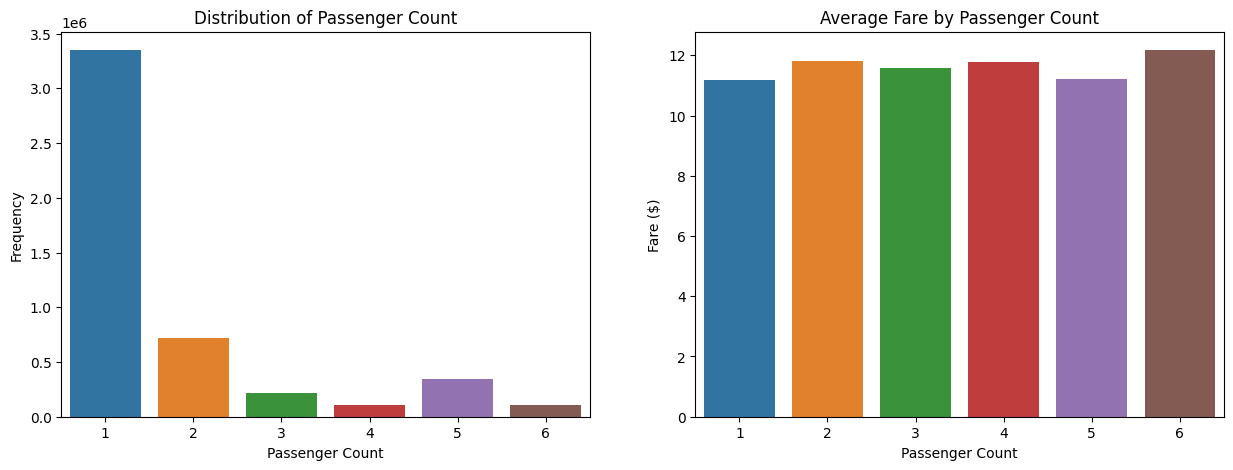

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(data = train, x = 'passenger_count', ax=ax[0])
ax[0].set_xlabel('Passenger Count')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Passenger Count')
sns.barplot(data = train, x = 'passenger_count', y = 'fare_amount', ax=ax[1], ci=None)
ax[1].set_xlabel('Passenger Count')
ax[1].set_ylabel('Fare ($)')
ax[1].set_title('Average Fare by Passenger Count')
fig.show()

## 上2つのグラフから分かることは、タクシーは1人で乗ることが多いということと、乗客人数と運賃は関係ないということ

## では、乗車距離と運賃の関係を調べる

Text(0, 0.5, 'Fare ($)')

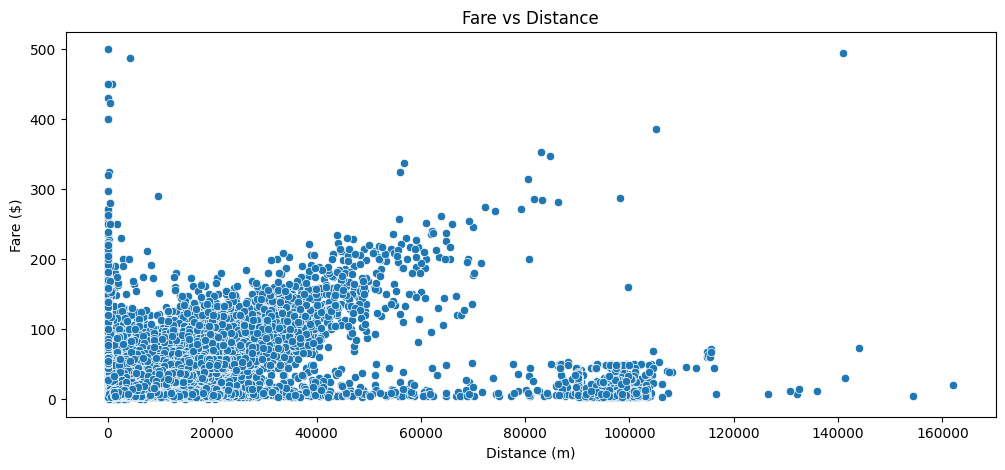

In [20]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(x='distance', y='fare_amount', data=train).set_title('Fare vs Distance')
plt.xlabel('Distance (m)')
plt.ylabel('Fare ($)')

距離が長くなるにつれて高くなるという関係が見られたが、2つの疑問が浮かぶ。
距離が～75kmを超えると、80～110kmの地点に50ドル以下の地点が集中するため、平均運賃は実際には減少する。交通量の少ない路線を利用しているのか？定額料金の旅行か？それとも誤ったデータか？

Text(0, 0.5, 'Long Trip Fare ($)')

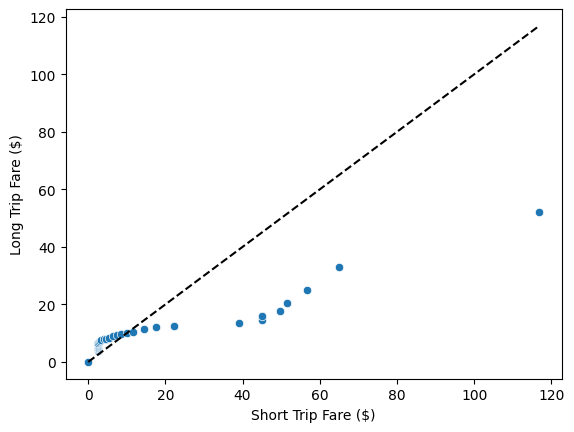

In [21]:
percs = np.linspace(0,99,34)
short = np.percentile(train[train['distance']<=50].fare_amount, percs)
long = np.percentile(train[train['distance']>50].fare_amount, percs)
sns.scatterplot(x=short, y=long)
x = np.linspace(np.min((short.min(),long.min())), np.max((short.max(),long.max())))
plt.plot(x,x, color="k", ls="--")
plt.title('')
plt.xlabel('Short Trip Fare ($)')
plt.ylabel('Long Trip Fare ($)')

In [22]:
ks = scipy.stats.ks_2samp(
    train.where(train.distance > 50).dropna()['fare_amount'],
    train.where(train.distance <= 50).dropna()['fare_amount']
)
print('p-value:', ks[1])

p-value: 0.0


## 75km以上の件数を確認する

In [23]:
long_trips = train[train.distance>75000].fare_amount.count()
print(long_trips, 'trips over 75km.')

788 trips over 75km.


## 75km超えるものが788件ある
この時の平均運賃を距離が短いときと比較する

In [24]:
# print('Average fare for distance over 75km:', train[train.distance>75000].fare_amount.mean())
# print('Average fare for distance 50-75km:', train.query('50000 < distance < 75000').fare_amount.mean())
# # sns.barplot(['50-75km', '>75km'],[train.query('50000 < distance < 75000').fare_amount.mean(),train[train.distance>75000].fare_amount.mean()])
# # sns.barplot(data=train, x = 'distance')
# plt.title('Fare by Trip Distance')
# plt.ylabel('Fare ($)')
# plt.xlabel('Distance')

長距離なのに運賃が安くなっていることがある\
それがなぜかを以下のグラフから考える

In [25]:
# def plot_long_trips(df):
#     rows=len(df)
#     fig, ax = plt.subplots(1, 1, figsize=(12, 12))
#     for i in range(rows):
#         plt.plot([df.pickup_longitude[i],df.dropoff_longitude[i]], [df.pickup_latitude[i], df.dropoff_latitude[i]], marker='o', color='b', alpha=0.1)
#     plt.title('Linked Pickup and Dropoff Points for Trips longer than 75km')
#     plt.ylabel('Latitude')
#     plt.xlabel('Longitude')
#     plt.show()    

# plot_long_trips(train[train.distance>75000].reset_index())

長距離路線の大半を供給しているのは明らかだが、この場所が低運賃の原因なのだろうか？

In [26]:
# print(train[train.distance>75000].query('41.36 < pickup_latitude < 41.37 or 41.36 < dropoff_latitude < 41.37')
#       .fare_amount.count(), f'of the {long_trips} trips with distance>75km start or end in this area')

# print(f'The average fare of these trips is',
#       train[train.distance>75000].query('41.36 < pickup_latitude < 41.37 or 41.36 < dropoff_latitude < 41.37')
#       .fare_amount.mean())

# print(f'The average fare of long trips starting and ending elsewhere is',
#       train[train.distance>75000].query('(41.36 > pickup_latitude or pickup_latitude > 41.37) and (41.36 > dropoff_latitude or dropoff_latitude > 41.37)')
#       .fare_amount.mean())

## 原因発見
長距離旅行の運賃を大幅に下げている大きな原因を見つけた。地図上で座標を確認すると、そこには何もないように見えるので、これらのデータポイントが正しくないかどうかは分からない。

## 時間の特徴と運賃はどのように相互作用する?
次に、時間的特徴が運賃とどのように相互作用するかを見てみる。

In [27]:
# train.pivot_table('fare_amount', index='year').plot(figsize=(15,2))
# plt.title('Fare Paid by Year')
# plt.ylabel('Fare ($)')
# plt.xlabel('Year')
# train.pivot_table('fare_amount', index='dayofyear').plot(figsize=(15,2))
# plt.title('Fare Paid by Day of Year')
# plt.ylabel('Fare ($)')
# plt.xlabel('Day')
# train.pivot_table('fare_amount', index='weekday').plot(figsize=(15,2))
# plt.title('Fare Paid by Weekday (Monday-Sunday)')
# plt.ylabel('Fare ($)')
# plt.xlabel('Day')
# train.pivot_table('fare_amount', index='time').plot(figsize=(15,2))
# plt.ylabel('Fare ($)')
# plt.xlabel('Time')
# plt.title('Fare Paid by Time of Day')
# plt.show()

## わかったこと
2009年から2015年にかけて、年ごとの平均運賃は着実に上昇しており、2012年から2013年にかけては明らかに急上昇している。

年間を通じて平均運賃は、1データポイントあたりのサンプル数が少ないことから予想されるように変動しているが、明らかな季節性が見られる。

運賃は土曜日が最も安く、日曜日が最も高いが、全体的には1週間を通じて非常に安定している（Y軸のスケールに注意）。

運賃は、午前5時頃に非常に大きなスパイクを示している。市内中心部からの距離とピックアップ時間の関係を見てみる。

In [28]:
# train.query('50 < distance').pivot_table('fare_per_km', index='hour', columns='weekday').plot(figsize=(15,2))
# plt.title('$ per KM vs Time of Day')
# plt.ylabel('$ per KM')
# plt.xlabel('24hr Time')
# train.pivot_table('distance', index='time', columns='weekday').plot(figsize=(15,2))
# plt.ylabel('Meters')
# plt.xlabel('24hr Time')
# plt.title('Trip Distance vs Time of Day')
# plt.show()

## 時間と移動距離、運賃について
## 面白いことに土曜と日曜の遅い時間が移動距離が長い
午前5時ごろの平均運賃の急上昇は、おそらく通勤時間帯であり、キロ単価が高いというよりも移動距離が長い結果であることがわかる。kmあたりの料金は、実際、午前9時から午後5時までの標準的な勤務時間帯に最も高くなる。

In [29]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 4))
# plt.plot(train.groupby('time').time.unique(), train.groupby('time')['pickup_dist_nyc'].mean()/1000, label='Pickup Distance')
# plt.plot(train.groupby('time').time.unique(), train.groupby('time')['dropoff_dist_nyc'].mean()/1000, label='Dropoff Distance')
# plt.legend(loc="upper right")
# plt.xlabel('24hr Time')
# plt.ylabel('Distance (km)')
# plt.legend()
# plt.title('Distance from City Centre vs Time of Day')

## 午前の長距離は、市内から外へ行く人のせいだった

In [30]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 4))
# plt.plot(train.groupby('time').time.unique(), train.groupby('time')['pickup_dist_nyc'].mean()/1000, label='Pickup Distance')
# plt.plot(train.groupby('time').time.unique(), train.groupby('time')['dropoff_dist_nyc'].mean()/1000, label='Dropoff Distance')
# plt.legend(loc="upper right")
# plt.xlabel('24hr Time')
# plt.ylabel('Distance (km)')
# plt.legend()
# plt.title('Distance from City Centre vs Time of Day')

## 空港うんぬんということが分かる

In [31]:
# sns.boxplot(x=train['close_to_airport'], y=train['fare_amount'])
# plt.title('Fare Distribution by Proximity to Airports')
# plt.ylim(-1,200)
# plt.xlabel('Close to Airport')
# plt.ylabel('Fare ($)')

## 空港が近いかで運賃変わる
## 次に乗る場所、下りる場所で運賃が変わるか

In [32]:
# def fare_heatmap(direction):
#     df = (
#         train
#         .groupby([f'{direction}_long_bucket', f'{direction}_lat_bucket'])
#         .fare_amount
#         .mean()
#         .unstack(level=0)
#         .iloc[::-1]
#     )
#     sns.heatmap(df, cmap="Blues", vmin= 0, vmax=30, ax=ax, cbar_kws={'label':'Average Fare ($)'})
#     plt.title(f'Average Fare by {direction} Location')
#     plt.ylabel('Latitude Bucket')
#     plt.xlabel('Longitude Bucket')
    
# fig = plt.figure(figsize=(10, 9))
# fig.subplots_adjust(wspace=0.2, right=1.8)
# ax = fig.add_subplot(1, 2, 1)
# fare_heatmap('pickup')
# ax = fig.add_subplot(1, 2, 2)
# fare_heatmap('dropoff')
# plt.show()

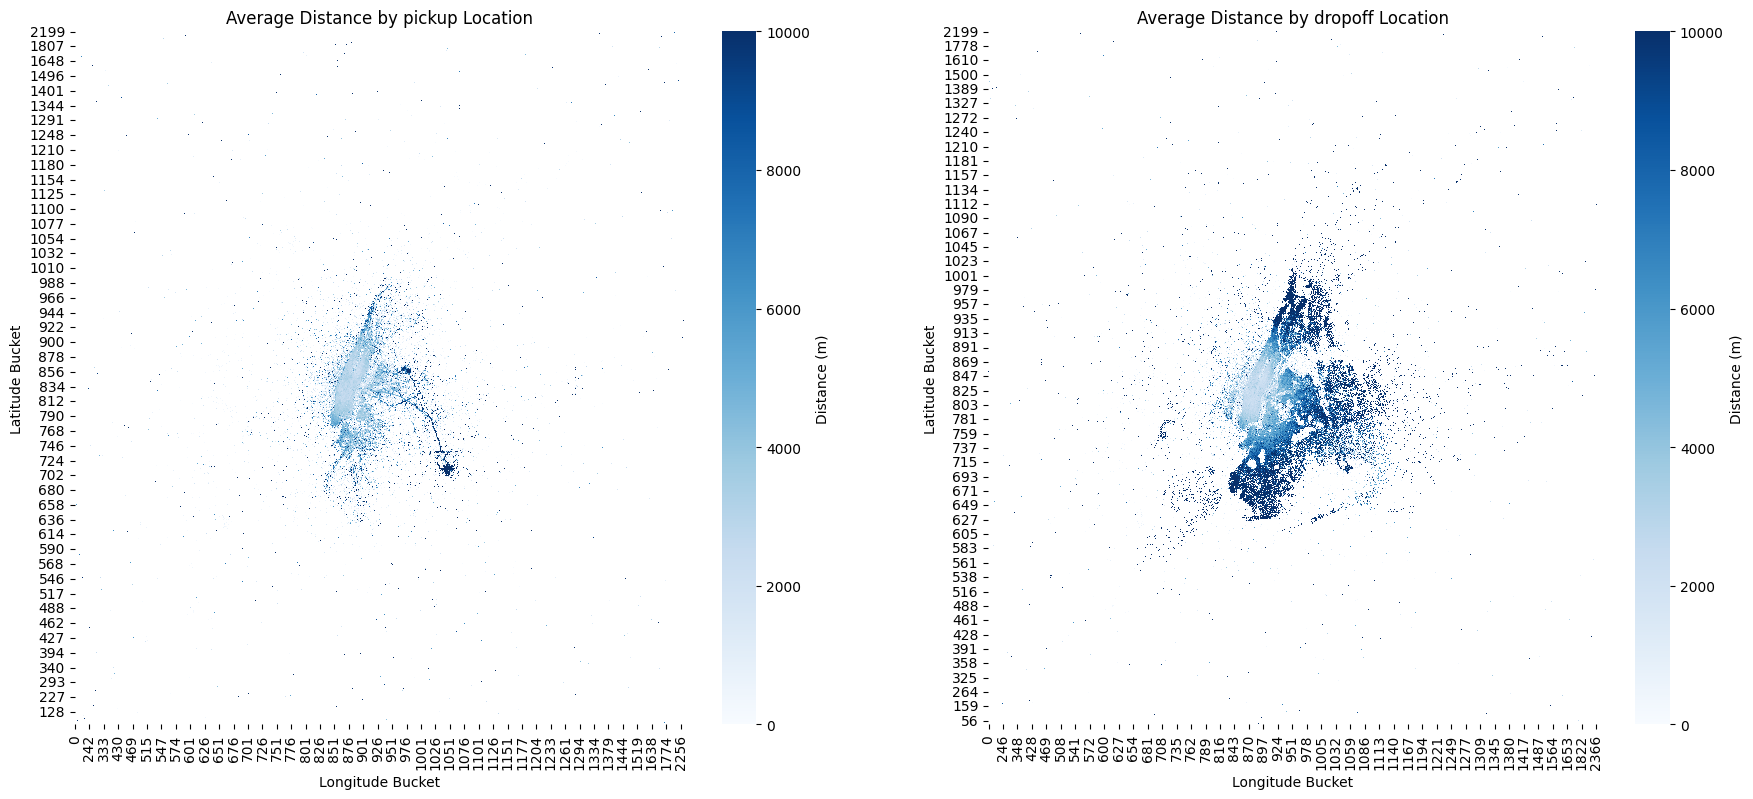

In [33]:
def dist_heatmap(direction):
    df = (
        train
        .groupby([f'{direction}_long_bucket', f'{direction}_lat_bucket'])
        .distance
        .mean()
        .unstack(level=0)
        .iloc[::-1]
    )
    sns.heatmap(df, cmap="Blues", vmin= 0, vmax=10000, ax=ax, cbar_kws={'label':f'Distance (m)'})
    plt.title(f'Average Distance by {direction} Location')
    plt.ylabel('Latitude Bucket')
    plt.xlabel('Longitude Bucket')
    
fig = plt.figure(figsize=(10, 9))
fig.subplots_adjust(wspace=0.2, right=1.8)
ax = fig.add_subplot(1, 2, 1)
dist_heatmap('pickup')
ax = fig.add_subplot(1, 2, 2)
dist_heatmap('dropoff')
plt.show()

## ヒートマップの説明
## 注目点

In [34]:
# def ratio_heatmap(direction):
#     df = (
#         train
#         .query(f'-74.1 < {direction}_longitude < -73.95')
#         .query(f'40.65 < {direction}_latitude < 40.8')
#         .groupby([f'{direction}_long_bucket', f'{direction}_lat_bucket'])
#         .fare_per_km
#         .mean()
#         .unstack(level=0)
#         .iloc[::-1]
#     )
#     sns.heatmap(df, cmap="viridis", vmin= 0, vmax=80, ax=ax, cbar_kws={'label':f'Fare per km ($)'})
#     plt.title(f'Average Fare Per km by {direction} Location')
#     plt.ylabel('Latitude Bucket')
#     plt.xlabel('Longitude Bucket')
    
# fig = plt.figure(figsize=(10, 9))
# fig.subplots_adjust(wspace=0.2, right=1.8)
# ax = fig.add_subplot(1, 2, 1)
# ratio_heatmap('pickup')
# ax = fig.add_subplot(1, 2, 2)
# ratio_heatmap('dropoff')
# plt.show()

## 最後に、移動の方向は支払った運賃に関係しているのかを調べる

In [35]:
# train.query('distance > 5').pivot_table('fare_per_km', index='direction_bucket', aggfunc='mean').plot(figsize=(15,2))
# plt.ylabel('Fare per km($)')
# plt.xlabel('Direction')
# plt.title('Fare Paid vs Direction')
# plt.show()

## 方位に基づいて調整された距離の特徴を作成する
ニューヨーク中心部の長さに沿って道路を上ったり下ったりする場合、方角によって～20度または～160度の方角を移動することになる。実際の移動距離は、道路に沿って直接移動した場合に最も近くなる。

## 最終結果を出す
## まず、訓練データから

In [36]:
def modelling_features(df):
    df = shared_features(df)
    # using alternative representation of cyclic features
    df = df.assign(
        sin_time=np.sin(2*np.pi*df['time']/24),
        cos_time=np.cos(2*np.pi*df['time']/24),
        sin_direction=np.sin(2*np.pi*df['direction']/360),
        cos_direction=np.cos(2*np.pi*df['direction']/360),
        sin_dayofyear=np.sin(2*np.pi*df['dayofyear']/365),
        cos_dayofyear=np.cos(2*np.pi*df['dayofyear']/365),
        sin_weekday=np.sin(2*np.pi*df['weekday']/6),
        cos_weekday=np.cos(2*np.pi*df['weekday']/6),
        direction_bucket=pd.cut(df['direction'], bins=37, labels=False)
        ).drop(columns=['pickup_datetime', 'time', 'direction', 'weekday', 'dayofyear'])
    return df

In [37]:
train = load_df(10000000, features='model')

test['pickup_datetime'] = test['pickup_datetime'].str.slice(0, 15)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
test = modelling_features(test)

train = (train
    .query(f'{test.pickup_longitude.min()-0.1} <= pickup_longitude <= {test.pickup_longitude.max()+0.1}')
    .query(f'{test.pickup_latitude.min()-0.1} <= pickup_latitude <= {test.pickup_latitude.max()+0.1}')
    .query(f'{test.dropoff_longitude.min()-0.1} <= dropoff_longitude <= {test.dropoff_longitude.max()+0.1}')
    .query(f'{test.dropoff_latitude.min()-0.1} <= dropoff_latitude <= {test.dropoff_latitude.max()+0.1}')
)

x_train, x_val, y_train, y_val = get_split_sets(train)

x_train['fare_per_km'] = y_train*1000/(x_train.distance+5)
fares_by_direction = x_train.query('5 < distance').groupby('direction_bucket')['fare_per_km'].mean()

x_train['adj_dist'] = [fares_by_direction[i] for i in x_train.direction_bucket]*x_train.distance/fares_by_direction.max()
x_val['adj_dist'] = [fares_by_direction[i] for i in x_val.direction_bucket]*x_val.distance/fares_by_direction.max()
test['adj_dist'] = [fares_by_direction[i] for i in test.direction_bucket]*test.distance/fares_by_direction.max()

x_train = x_train.drop(columns=['fare_per_km', 'direction_bucket'])
x_val = x_val.drop(columns=['direction_bucket'])
x_test = test.drop(columns=['key', 'direction_bucket'])

In [38]:
lin_final_model, lin_final_rmse, lin_final_pred = lin_model(x_train, x_val, y_train, y_val)

In [39]:
knn_cols = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']
k_choices = [18,24,30,40]
knn_final_model, knn_final_rmse, knn_final_pred = knn_model(x_train[knn_cols], x_val[knn_cols], y_train, y_val, k_choices)

Neighbours 18 RMSE 4.0092439163794875
Neighbours 24 RMSE 3.995900356000559
Neighbours 30 RMSE 3.9883519999871275
Neighbours 40 RMSE 3.9861903317282


In [40]:
lgbm_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'reg_sqrt': True,
    'learning_rate': 0.03,
    'num_leaves': 1200,
    'max_depth': -1,
    'max_bin': 5000,
    'num_rounds': 5000,
    'early_stopping_round': 50,
    'metric': 'rmse'
}
lgbm_final_model, lgbm_final_rmse, lgbm_final_pred = lgbm_model(lgbm_params, x_train, x_val, y_train, y_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.540408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100862
[LightGBM] [Info] Number of data points in the train set: 8781381, number of used features: 28
[LightGBM] [Info] Start training from score 3.177625
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.63247
[200]	valid_0's rmse: 3.47915
[300]	valid_0's rmse: 3.4394
[400]	valid_0's rmse: 3.4222
[500]	valid_0's rmse: 3.41444
[600]	valid_0's rmse: 3.40987
[700]	valid_0's rmse: 3.4066
[800]	valid_0's rmse: 3.40412
[900]	valid_0's rmse: 3.40201
[1000]	valid_0's rmse: 3.40023
[1100]	valid_0's rmse: 3.39909
[1200]	valid_0's rmse: 3.39799
[1300]	valid_0's rmse: 3.39676
[1400]	valid_0's rmse: 3.3958
[1500]	valid_0's rmse: 3.39519
[1600]	valid_0's rmse: 3.39416
[1700]	valid_0's rmse: 3.3935
[1800]	valid_0's rmse: 3.39272
[1900]	valid_0's rmse: 3.39208
[2000]	valid_0's r

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

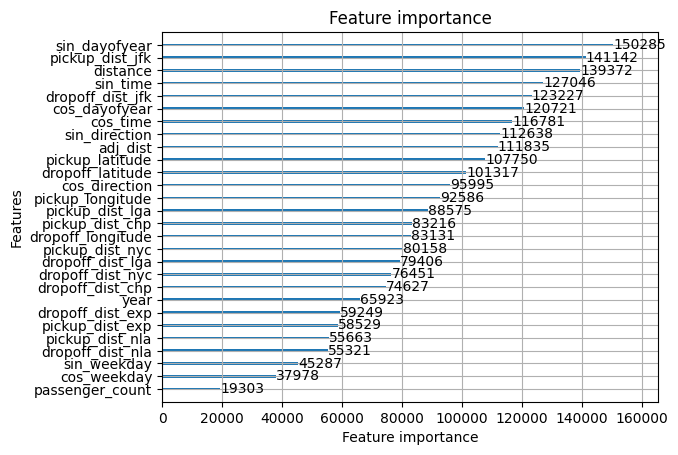

In [41]:
lgbm.plot_importance(lgbm_final_model)

In [42]:
print('Linear Regression RMSE', lin_final_rmse)
print('KNN RMSE', knn_final_rmse)
print('LightGBM RMSE', lgbm_final_rmse)

Linear Regression RMSE 4.837239244842347
KNN RMSE 3.9861903317282
LightGBM RMSE 3.3910724485223382


## 何らかの利益がえられるかを次のコードで確かめる


In [43]:
d = {}
for a in np.linspace(0,1,101):
    final_preds_ave = (lgbm_final_pred*(1-a) + knn_final_pred * a)
    rmse = np.sqrt(mean_squared_error(y_val, final_preds_ave))
    d[a] = rmse
alpha = min(d, key=d.get)
print('Best weight to give KNN: ', alpha)

Best weight to give KNN:  0.05


## KNNの重みが0.06なら一番性能がよくなった

In [44]:
lgbm_test_pred = lgbm_final_model.predict(x_test, num_iteration=lgbm_final_model.best_iteration)
knn_test_pred = knn_final_model.predict(x_test[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']])
submission_pred = (lgbm_test_pred*(1-alpha) + knn_test_pred * alpha)
submission = pd.DataFrame({'key': test.key, 'fare_amount': submission_pred})
submission.to_csv('submission_10_10_20_comb.csv', index=False)

## 最終的に2.93のRMSEを達成できた。